The objective of this notebook is to reescale DDSM images to smaller size (1152x896)

For each case in the dataset, we will:

1. Rescale the image (with antialias as nikulin)
2. Save the image in the same folder 
3. Generate mask images for all lessions in the image, and save them in the same folder rescaled as well
4. Update a csv file with the information of the lessions in the image (bounding box, type, pathology, etc)


In [220]:
import pathlib
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2  
import os
import sys  
import pandas as pd


sys.path.append('../lib')
from annotation_utils import read_annotation_image

In [221]:
ddsm_root_folder = pathlib.Path('/media/HD/mamo/DDSM_png')
target_size = (1152,896)

HOME = os.environ['HOME']
dest_root_folder = pathlib.Path(HOME + f'/Data/mamo/DDSM_png_{target_size[0]}x{target_size[1]}')
print("target folder: ", dest_root_folder)

ddsm_images = list(ddsm_root_folder.glob('**/*.png'))
print("Number of images: ", len(ddsm_images))

ddsm_df = pd.DataFrame(ddsm_images, columns=['original_path'])

target folder:  /home/alalbiol/Data/mamo/DDSM_png_1152x896
Number of images:  10420


In [222]:
def get_overlay_file(png_image):
    overlay_file = pathlib.Path(str(png_image).replace('.png', '.OVERLAY'))
    return overlay_file if overlay_file.exists() else None

ddsm_df['overlay_path'] = ddsm_df['original_path'].apply(get_overlay_file)

print("Number of images with overlay: ", ddsm_df['overlay_path'].count())

Number of images with overlay:  4029


In [223]:

def resize_image(image, target_size, annotations=None):
    # apply gaussian blur first as antialias
    # target_size = (1152,896) # (height x width)
    original_size = (image.shape[0], image.shape[1]) # (height x width)
    scale_x = target_size[1] / original_size[1]
    scale_y = target_size[0] / original_size[0]
    
    if annotations is not None:
        new_annotations = []
        for annotation in annotations:
            new_annotation = annotation.copy()
            
            #[xmin, ymin, xmax, ymax, centerx, centery, width, height]
            boundary = new_annotation['outline']
            new_boundary = (boundary[0]* scale_x, boundary[1]*scale_y)
            new_bounding_box = new_annotation['bounding_box'].copy()
            
        
            #[xmin, ymin, xmax, ymax, centerx, centery, width, height]
            for i in [0, 2, 4, 6]:  # Indices for x values
                new_bounding_box[i] *= scale_x
            for i in [1, 3, 5, 7]:  # Indices for y values
                new_bounding_box[i] *= scale_y


            new_annotation['outline'] = new_boundary
            new_annotation['bounding_box'] = new_bounding_box
            
            
            new_annotations.append(new_annotation)
        
    
    resized_image = cv2.resize(image, (target_size[1], target_size[0])   , interpolation = cv2.INTER_LANCZOS4)
    if annotations is not None:
        return resized_image, new_annotations
    
    return resized_image


def create_abnormality_mask(image, outline):
    # Create a blank mask with the same shape as the image and 3 channels (if the image is colored)
    mask = np.zeros(image.shape, dtype=np.uint8)
    
    # Combine x and y coordinates into a single array of shape (n, 2)
    coords = np.array(list(zip(outline[0], outline[1]))).reshape(-1, 1, 2).astype(np.int32)
    
    # Fill the mask with the polygon defined by the outline
    mask = cv2.fillPoly(mask, [coords], 255)
    
    return mask


(3241, 5341)


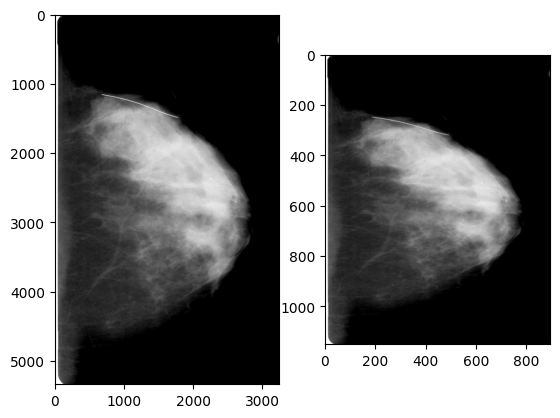

In [224]:
image = Image.open(ddsm_df['original_path'][0])
print(image.size)
fig, ax = plt.subplots(1,2)

resized_image = resize_image(np.array(image), target_size)

ax[0].imshow(image, cmap='gray')
ax[1].imshow(resized_image, cmap='gray')

In [225]:
ddsm_annotations = ddsm_df.loc[ddsm_df['overlay_path'].notnull()]

n = 1

annotated_image = ddsm_annotations.iloc[n]['original_path']
image = Image.open(annotated_image)
annotations = read_annotation_image(ddsm_annotations.iloc[n]['overlay_path'])

print(ddsm_annotations.iloc[n]['original_path'])
print(ddsm_annotations.iloc[n]['overlay_path'])

print("number of annotations in the image: ", len(annotations))

image_resized, annotations_resized = resize_image(np.array(image), target_size, annotations)


/media/HD/mamo/DDSM_png/cancers/cancer_13/case4124/D_4124_1.RIGHT_MLO.png
/media/HD/mamo/DDSM_png/cancers/cancer_13/case4124/D_4124_1.RIGHT_MLO.OVERLAY
number of annotations in the image:  1


In [226]:
print("image shape", np.array(image).shape)
x, y = annotations[0]['outline']

print("xmin: ", min(x), "xmax: ", max(x))
print("ymin: ", min(y), "ymax: ", max(y))

image shape (5386, 3751)
xmin:  2803 xmax:  3575
ymin:  4058 ymax:  4810


[3399 3399 3398 ... 3401 3400 3399]
[4770 4770 4770 ... 4768 4769 4770]


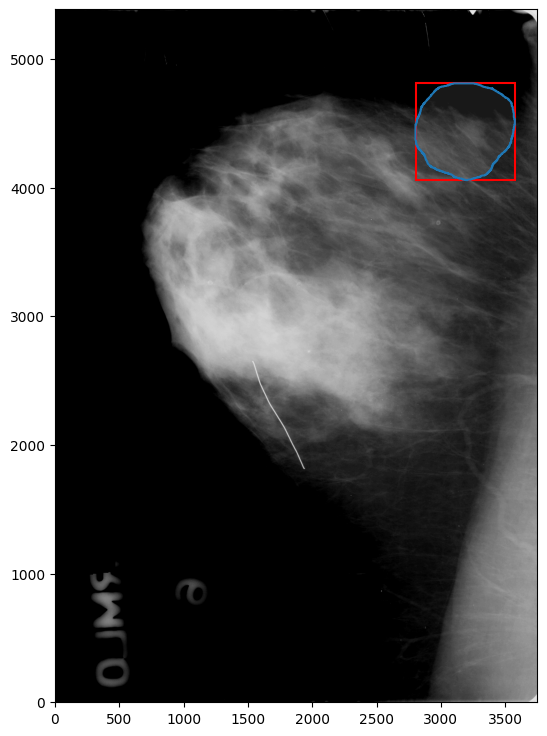

In [227]:

def plot_annot(im,a):
    """Plot image with annotation."""
    f,ax=plt.subplots(figsize=(9,9))
    plt.imshow(im,cmap='gray')
    
    x = a['outline'][0]
    y = a['outline'][1]
    
    print(x)
    print(y)
    
    plt.plot(x,y)
    plt.xlim(0,im.shape[1])
    plt.ylim(0,im.shape[0])
    
    bb=a['bounding_box']
    ax.add_patch(
        plt.Rectangle((bb[0], bb[1]),
                       bb[-2],
                       bb[-1], fill=False,
                       edgecolor='red', linewidth=1.5))
    
    outline = a['outline']
    mask = create_abnormality_mask(im, outline)
    plt.imshow(mask, cmap='gray', alpha=0.1)

plot_annot(np.array(image), annotations[0])  
    


[811.91788856 811.91788856 811.67901893 ... 812.39562783 812.1567582
 811.91788856]
[1020.24507984 1020.24507984 1020.24507984 ... 1019.81730412 1020.03119198
 1020.24507984]


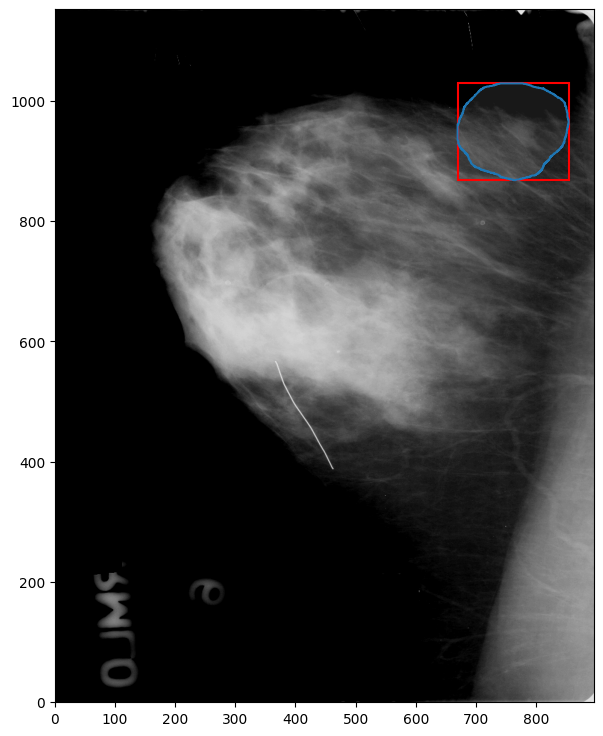

In [228]:
plot_annot(np.array(image_resized), annotations_resized[0])  


In [230]:
def rescale_all_ddsm(ddsm_df, target_size=(1152,896)):
    
    all_annotations = []
    for i in range(len(ddsm_df)):
        annotated_image = ddsm_df.iloc[i]['original_path']
        image = Image.open(annotated_image)
        
        if ddsm_df.iloc[i]['overlay_path'] is not None:
            annotations = read_annotation_image(ddsm_df.iloc[i]['overlay_path'])
            image_resized, annotations_resized = resize_image(np.array(image), target_size, annotations)
        else:
            annotations = None    
            image_resized = resize_image(np.array(image), target_size)
            annotations_resized = None
        
        dest_path = dest_root_folder / ddsm_df.iloc[i]['original_path'].relative_to(ddsm_root_folder)
        
        if dest_path.parent.exists() is False:
            dest_path.parent.mkdir(parents=True)
        
    
        image_resized = Image.fromarray(image_resized)
        image_resized.save(str(dest_path))
        
        #print("dest_path: ", dest_path)
        
        if annotations_resized is not None:
            
            image_id = "/".join(dest_path.parts[-4:])
            
            for k, annotation_resized in enumerate(annotations_resized):
                annotation_resized['image_id'] = image_id
                annotation_resized['mask_id'] = f'{image_id.replace(".png", "")}_mask_{k}.png'
                
                mask = create_abnormality_mask(np.array(image_resized), annotation_resized['outline'])
                
                mask_path = dest_root_folder / f'{annotation_resized["mask_id"]}'
                mask_image = Image.fromarray(mask)
                mask_image.save(str(mask_path))
                #print(mask_path)
                
                all_annotations.append(annotation_resized)
                
                print("annotation ", annotation_resized)
            
        
            
            if len(annotations_resized)>1:
                print(annotation_resized)
            
            
            if  i % 100 == 0:
                break
    all_annotations = pd.DataFrame(all_annotations)
    return all_annotations
        


In [243]:
# select a subset of the images that contain normals in path

df_normals = ddsm_df[ddsm_df['original_path'].astype(str).str.contains('normal')]

print(len(df_normals))
df_normals.head()


all_annotations_normals  = rescale_all_ddsm(df_normals, target_size)

2780


KeyboardInterrupt: 

In [211]:
all_annotations = rescale_all_ddsm(ddsm_df, target_size)
print(all_annotations)

annotation  {'type': 'MASS', 'assessment': 3, 'subtlety': 3, 'pathology': 'MALIGNANT', 'outline': (array([793.33862734, 793.33862734, 793.08451503, ..., 793.84685196,
       793.59273965, 793.33862734]), array([783.86180999, 783.86180999, 783.86180999, ..., 783.42921517,
       783.64551258, 783.86180999])), 'bounding_box': [643.9205899035734, 648.0270371761171, 851.2762336925695, 793.3788959819752, 747.5984117980714, 720.7029665790462, 207.60975609756096, 145.56815621479535], 'breast_malignant': True, 'image_id': 'cancers/cancer_13/case4124/D_4124_1.RIGHT_CC.png', 'mask_id': 'cancers/cancer_13/case4124/D_4124_1.RIGHT_CC_mask_0.png'}
annotation  {'type': 'MASS', 'assessment': 3, 'subtlety': 3, 'pathology': 'MALIGNANT', 'outline': (array([811.91788856, 811.91788856, 811.67901893, ..., 812.39562783,
       812.1567582 , 811.91788856]), array([1020.24507984, 1020.24507984, 1020.24507984, ..., 1019.81730412,
       1020.03119198, 1020.24507984])), 'bounding_box': [669.5515862436683, 867.95

In [219]:
ddsm_df

,original_path
0,/media/HD/mamo/DDSM_png/cancers/cancer_13/case...
1,/media/HD/mamo/DDSM_png/cancers/cancer_13/case...
2,/media/HD/mamo/DDSM_png/cancers/cancer_13/case...
3,/media/HD/mamo/DDSM_png/cancers/cancer_13/case...
4,/media/HD/mamo/DDSM_png/cancers/cancer_13/case...
...,...
10415,/media/HD/mamo/DDSM_png/benigns/benign_12/case...
10416,/media/HD/mamo/DDSM_png/benigns/benign_12/case...
10417,/media/HD/mamo/DDSM_png/benigns/benign_12/case...
10418,/media/HD/mamo/DDSM_png/benigns/benign_12/case...
